In [178]:
d = 2
mu = np.array([-1, 0.02, 0.02])
T = 500
dt = 1
kappa = np.array([-1, 0.1, 0.1])

size = 20

noise_std = 0.01

In [179]:
class Point():
    def __init__(self, point_type, x, t_1, t_2):
        self.point_type = point_type
        self.x = x
        self.t_1 = t_1
        self.t_2 = t_2
        
        
    def shifted(self, v, dt):
        v = np.array(v)
        return Point(self.point_type, self.x + v, self.t_2, self.t_2 + dt)
    
    def __lt__(self, other):
        d_self = self.t_2 - self.t_1
        d_other = other.t_2 - other.t_1
        
        if d_self == d_other:
            if self.t_1 < other.t_1:
                return True
            elif self.t_1 == other.t_1:
                return self.t_2 < other.t_2
            return False
        elif d_self < d_other:
            return True
        
        return False
    
    def __str__(self):
        return '{} {} {} {} {}'.format(self.point_type, self.x[0], self.x[1], self.t_1, self.t_2)
    

In [180]:
def init_points_2d(size):
    R = []
    
    for i in range(-size, size, 1):
        for j in range(-size, size, 1):
            R.append(Point(1, np.array([i, j]), 0, 0))
            R.append(Point(2, np.array([i, j]), 0, 0))
            #if i == 0 and j == 0:
            #    R.append(Point(1, np.array([i, j]), 0, 0))
            #    R.append(Point(2, np.array([i, j]), 0, 0))
                
            
    return R

In [181]:
def beta(point_type, k, l):
    if point_type == 1:
        return 0
    
    if point_type == 2:
        if k == 1:
            if l == 1:
                return 0.5
        if k == 0:
            if l == 2:
                return 0.5      
        
def a(v):
    l = np.sum(np.abs(v))
    if l == 1:
        return 0.5
    if l == 2:
        return 0.25



1. Бродит по решенке с конечной дисперсией скачков
2. Дает потомство только в 0 (b_0 = b_2)

1. Бродит по решенке с конечной дисперсией скачков
2. Дает потомство в любой точке (b_0 = b_2)

In [182]:
def append_points(R, k, l, p, dt):
    for i in range(k):
        coord_noise = np.random.normal(0, noise_std, 2)
        R.append(Point(1, p.x + coord_noise, p.t_2, p.t_2 + dt))
        
    for i in range(l):
        coord_noise = np.random.normal(0, noise_std, 2)
        R.append(Point(2, p.x + coord_noise, p.t_2, p.t_2 + dt))
    
def get_elements_probas(p):
    elements = [
        'die',
        '(1, 1)',
        '(0, 2)',
        'x + (0, 1)',
        'x + (1, 0)',
        'x + (1, 1)',
        'x + (2, 0)',
        'x + (0, 2)',
        'x + (0, -1)',
        'x + (-1, 0)',
        'x + (-1, -1)',
        'x + (-2, 0)',
        'x + (0, -2)'
    ]

    probas = [
        mu[p.point_type],
        beta(p.point_type, 1, 1),
        beta(p.point_type, 0, 2),
        a([0, 1]),
        a([1, 0]),
        a([1, 1]),
        a([2, 0]),
        a([0, 2]),
        a([0, -1]),
        a([-1, 0]),
        a([-1, -1]),
        a([-2, 0]),
        a([0, -2])
    ]
    
    return elements, probas / np.sum(probas)
    
def step(R, H, dt, idx):
    p = R[idx]
    
    elements, probas = get_elements_probas(p)
    
    action = np.random.choice(a=elements, p=probas, size=1)[0]
    
    coord_noise = np.random.normal(0, noise_std, 2)
    
    if action == '(1, 1)':
        append_points(R, 1, 1, p, dt)
    elif action == '(0, 2)':
        append_points(R, 1, 1, p, dt)
    elif action == 'x + (0, 1)':
        R.append(p.shifted([0, 1] + coord_noise, dt))
    elif action == 'x + (1, 0)':
        R.append(p.shifted([1, 0] + coord_noise, dt))
    elif action == 'x + (1, 1)':
        R.append(p.shifted([1, 1] + coord_noise, dt))
    elif action == 'x + (2, 0)':
        R.append(p.shifted([2, 0] + coord_noise, dt))
    elif action == 'x + (0, 2)':
        R.append(p.shifted([0, 2] + coord_noise, dt))
    elif action == 'x + (0, -1)':
        R.append(p.shifted([0, -1] + coord_noise, dt))
    elif action == 'x + (-1, 0)':
        R.append(p.shifted([-1, 0] + coord_noise, dt))
    elif action == 'x + (-1, -1)':
        R.append(p.shifted([-1, -1] + coord_noise, dt))
    elif action == 'x + (-2, 0)':
        R.append(p.shifted([-2, 0] + coord_noise, dt))
    elif action == 'x + (0, -2)':
        R.append(p.shifted([0, -2] + coord_noise, dt))
    
        
    H.append(p)
    del R[idx]

In [183]:
def simulate(R, H, max_steps=10000):
    k = 0
    
    
    while k < max_steps:
        i = 0
        idx = 0
        found = 0
        
        if k % 10000 == 0:
            print(k)
        
        while 1:
            if len(R) == 0:
                break

            idx = np.random.randint(len(R))

            if R[idx].t_2 < T:
                found = 1
                break
            if i >= len(R):
                break
            
            i += 1
        
        if len(R) == 0:
            return
        
        if found != 1:
            return
        
        dt = np.random.exponential()
        step(R, H, dt, idx)
        
        k += 1

In [184]:
R = init_points_2d(size)
H = []

In [185]:
simulate(R, H, max_steps=5000000)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

In [186]:
%%time
all_points = np.array(sorted(R + H))

CPU times: user 1min 1s, sys: 268 ms, total: 1min 1s
Wall time: 1min 1s


In [187]:
def plot_points(t):
    coords = [[], []]
    
    for p in (R + H):
        if p.t_1 <= t < p.t_2:
            coords[p.point_type - 1].append(p.x)
    coords_1 = np.array(coords[0]).T
    coords_2 = np.array(coords[1]).T
    
    
    if len(coords_1) > 0:
        plt.scatter(coords_1[0], coords_1[1], label='Man', alpha=0.2)
    if len(coords_2) > 0:
        plt.scatter(coords_2[0], coords_2[1], label='Woman', alpha=0.2)
    
    if len(coords_1) + len(coords_2) > 0:
        plt.legend()
        
    plt.grid()
    plt.plot()

In [188]:
def get_max_t(R, H):
    max_t = 0
    for p in (R + H):
        if p.t_2 > max_t:
            max_t = p.t_2
            
    for p in H:
        if p.t_2 > max_t:
            max_t = p.t_2
            
    return max_t

In [189]:
from intervaltree import Interval, IntervalTree

def build_interval_tree(points):
    interval_tree = IntervalTree()
    
    for i in tqdm(range(len(points))):
        p = points[i]
        if p.t_1 + p.t_2 > 0:
            interval_tree.add(Interval(p.t_1, p.t_2, i))

    return interval_tree

In [190]:
def plot_points_1(t, points, interval_tree, xlim, ylim):
    coords = [[], []]
    
    idx = list(map(lambda i: i.data, interval_tree.at(t)))
    
    points_t = points[idx]
    
    
    color_dict = {
        1: 'C0',
        2: 'C1'
    }
    
    label_dict = {
        'C0': 'Men',
        'C1': 'Women'
    }
    
    x_y = np.array(list(map(lambda p: p.x, points_t)))
    
    labels = np.array(list(map(lambda p: color_dict[p.point_type], points_t)))

    n_mens = np.sum(labels == 'C0')
    n_womens = np.sum(labels == 'C1')
    
    if len(x_y) > 0:
        
        fig, ax = plt.subplots()
        
        for color in ['C0', 'C1']:   
            ax.scatter([], [], c=color, label=label_dict[color])
        
        ax.scatter(x_y.T[0], x_y.T[1], c=labels, alpha=0.5)
        plt.grid()
        plt.legend()
        plt.suptitle('Mens: {}; Womens: {}'.format(n_mens, n_womens))
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.show()

        

In [191]:
interval_tree = build_interval_tree(all_points)

100%|██████████████████████████████| 5026407/5026407 [02:55<00:00, 28694.59it/s]


In [192]:
max_t = get_max_t(R, H)

In [193]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [194]:
def get_min_coords(all_points):
    min_x = min_y = max_x = max_y = 0
    for point in all_points:
        if point.x[0] < min_x:
            min_x = point.x[0]
        if point.x[1] < min_y:
            min_y = point.x[1]
        if point.x[0] > max_x:
            max_x = point.x[0]
        if point.x[1] > max_y:
            max_y = point.x[1]

    return (min_x, min_y, max_x, max_y)

In [195]:
min_x, min_y, max_x, max_y = get_min_coords(all_points)
print(min_x, max_x, min_y, max_y)

-93.16581876050509 90.96854691892649 -73.93697651183598 69.94443813699243


In [196]:
interact(lambda t: plot_points_1(t, all_points, interval_tree, [min_x, max_x], [min_y, max_y]), t=(0, min(max_t, T)))

interactive(children=(FloatSlider(value=164.08524367331717, description='t', max=328.17048734663433), Output()…

<function __main__.<lambda>(t)>

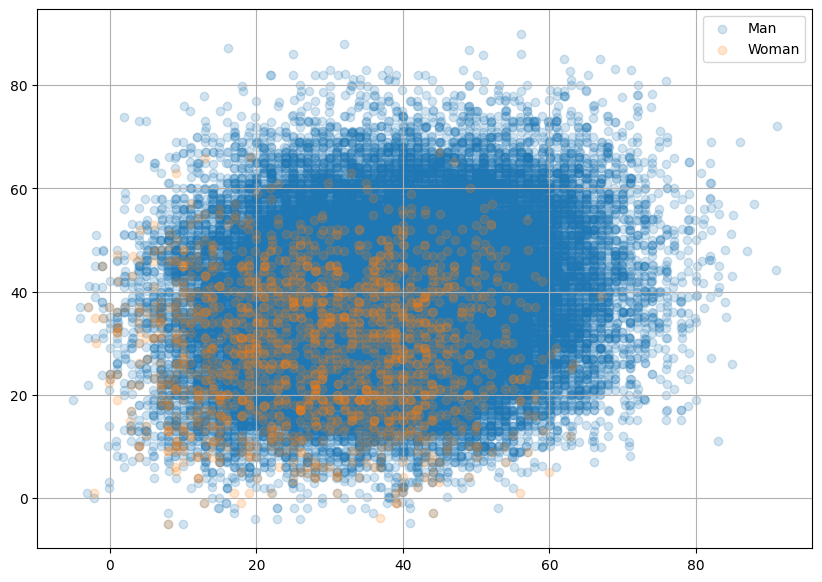

In [735]:
plot_points(65)

In [637]:
def get_ts(R, H):
    t_1s = []
    t_2s = []
    for p in R:
        t_1s.append(p.t_1)
        t_2s.append(p.t_2)
    for p in H:
        t_1s.append(p.t_1)
        t_2s.append(p.t_2)
    
    return t_1s, t_2s

In [657]:
t_1s, t_2s = get_ts(R, H)

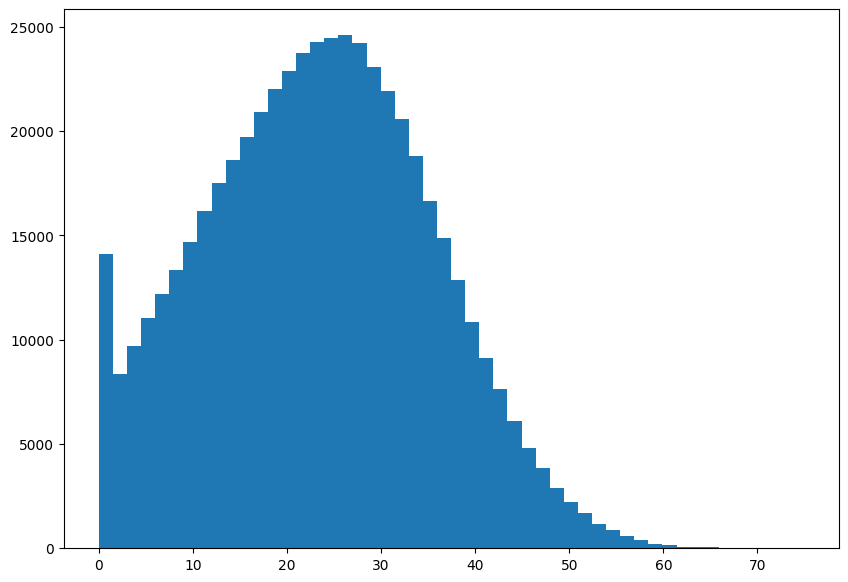

In [658]:
plt.hist(t_1s, bins=50)
plt.show()

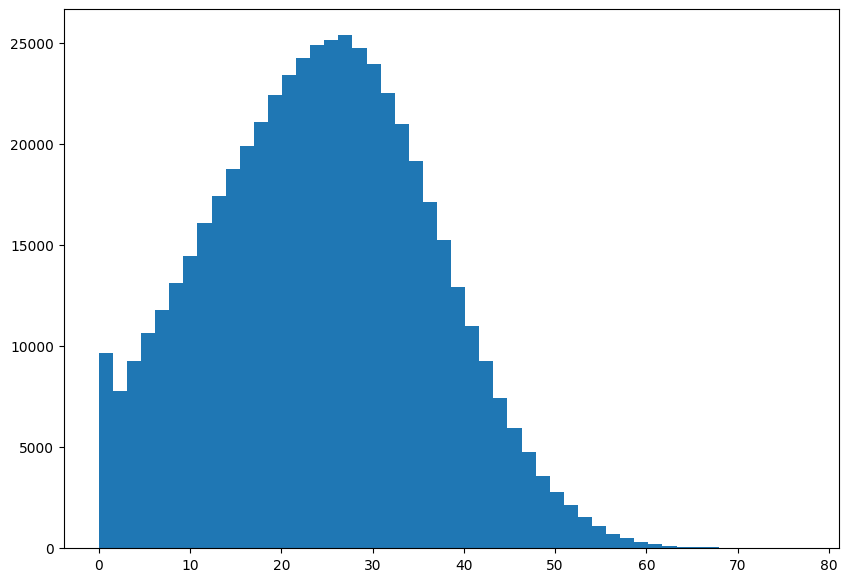

In [659]:
plt.hist(t_2s, bins=50)
plt.show()